In [ ]:
import pandas as pd
from google.colab import drive
import numpy as np
import os, json, gc, re, random
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
%%time

!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
CPU times: user 27.7 ms, sys: 3.94 ms, total: 31.7 ms
Wall time: 3.93 s


In [ ]:
%%time

!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 106.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 2

In [ ]:
%%time

!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
CPU times: user 34.6 ms, sys: 3.08 ms, total: 37.7 ms
Wall time: 4.32 s


In [ ]:
%%time

!pip install tokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.4 MB/s eta 0:00:00
CPU times: user 45.2 ms, sys: 7.03 ms, total: 52.3 ms
Wall time: 6.05 s


In [ ]:
drive.mount('/content/gdrive')
veri=pd.read_excel("/content/gdrive/My Drive/Deneme/temiz.xlsx")

Mounted at /content/gdrive


In [ ]:
del veri["Unnamed: 0"]
veri = veri.dropna()
veri = veri[["findings", "impression"]]
veri.columns = ['input_text', 'target_text']
veri

,input_text,target_text
0,pa and lateral views of the chest provi...,no acute intrathoracic process
1,as compared to the prior examination dat...,no evidence of acute cardiopulmonary process
2,a triangular opacity in the right lung ...,right upper lobe pneumonia or mass howev...
3,mild to moderate enlargement of the card...,no radiographic evidence for pneumonia
4,there is mild pulmonary edema with super...,mild pulmonary edema with superimposed le...
...,...,...
36712,a rightsided portacath terminates at the ...,no acute intrathoracic process
36713,there is no evidence of pneumothorax or ...,no evidence of pneumothorax or displaced ...
36714,the lungs are clear without focal consol...,no acute cardiopulmonary process
36715,suspect background hyperinflation as can ...,no acute pulmonary process identified no ...


In [ ]:
%%time

from simpletransformers.seq2seq import Seq2SeqModel

eval_df = veri.sample(frac=0.1, random_state=42)
train_df = veri.drop(eval_df.index)

model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "max_seq_length": 512,
    "train_batch_size": 8,
    "num_train_epochs": 5,
    "use_multiprocessing": False,
    "truncation": True,
    "tokenizer": True,
}
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer=AutoTokenizer.from_pretrained("facebook/bart-base")
# Create a Bart-base model
model = Seq2SeqModel(encoder_decoder_type="bart",
                    encoder_decoder_name="facebook/bart-base",
                    args=model_args)

CPU times: user 10.7 s, sys: 2.42 s, total: 13.1 s
Wall time: 27.2 s


In [ ]:
train_df

,input_text,target_text
0,pa and lateral views of the chest provi...,no acute intrathoracic process
1,as compared to the prior examination dat...,no evidence of acute cardiopulmonary process
2,a triangular opacity in the right lung ...,right upper lobe pneumonia or mass howev...
3,mild to moderate enlargement of the card...,no radiographic evidence for pneumonia
5,the lungs are clear of consolidation eff...,no acute cardiopulmonary process
...,...,...
36712,a rightsided portacath terminates at the ...,no acute intrathoracic process
36713,there is no evidence of pneumothorax or ...,no evidence of pneumothorax or displaced ...
36714,the lungs are clear without focal consol...,no acute cardiopulmonary process
36715,suspect background hyperinflation as can ...,no acute pulmonary process identified no ...


In [ ]:
%%time

# Train the model
model.train_model(train_df)

# Evaluate the model
result = model.eval_model(eval_df)
print(result)

  0%|          | 0/33036 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/4130 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/4130 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/4130 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/4130 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/4130 [00:00<?, ?it/s]

In [ ]:
cols = ['True Impression', 'Predicted Impression']
lst = []
test_df = eval_df.sample(n=400)
outputdata = pd.DataFrame()
for idx, row in test_df.iterrows():

    plot = row['input_text']
    true_title = row['target_text']
    predicted_title = model.predict([plot])[0]
    lst.append([true_title,predicted_title])

    print(f'True Impression: {true_title}\n')
    print(f'Predicted Impression: {predicted_title}\n')
    print(f'Findings: {plot}\n\n\n')

In [ ]:
outputdata = pd.DataFrame(lst,columns=cols)
outputdata

In [ ]:
outputdata.to_excel("cleanfacebook.xlsx")

In [ ]:
from google.colab import files
files.download("cleanfacebook.xlsx")

In [ ]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu


# BLEU skorlarını hesaplama
bleu_scores = []
for index, row in outputdata.iterrows():
    predicted_impression = row["Predicted Impression"]
    true_impression = row["True Impression"]
    bleu_score = sentence_bleu([true_impression], predicted_impression, weights=(0.5, 0.5))
    bleu_scores.append(bleu_score)

# BLEU skorlarının ortalamasını hesaplama
average_bleu_score = sum(bleu_scores) / len(bleu_scores)

# Sonucu yazdırma
print("Ortalama BLEU Skoru:", average_bleu_score)

In [ ]:
%time

!pip install rouge

In [ ]:
df=pd.read_excel("/content/gdrive/My Drive/Deneme/cleanfacebook.xlsx")

In [ ]:
from rouge import Rouge
def compute_rouge(predictions, targets):
    predictions = [" ".join(prediction).lower() for prediction in predictions]
    predictions = [prediction if prediction else "EMPTY" for prediction in predictions]
    targets = [" ".join(target).lower() for target in targets]
    targets = [target if target else "EMPTY" for target in targets]
    rouge = Rouge()
    scores = rouge.get_scores(hyps=predictions, refs=targets, avg=True)
    return scores['rouge-2']['f']

compute_rouge(df["Predicted Impression"], df["True Impression"])

LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')
data=pd.read_excel("/content/gdrive/My Drive/Deneme/temiz.xlsx")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data.dropna()

,Unnamed: 0,findings,impression
0,1,pa and lateral views of the chest provi...,no acute intrathoracic process
1,3,as compared to the prior examination dat...,no evidence of acute cardiopulmonary process
2,7,a triangular opacity in the right lung ...,right upper lobe pneumonia or mass howev...
3,9,mild to moderate enlargement of the card...,no radiographic evidence for pneumonia
4,11,there is mild pulmonary edema with super...,mild pulmonary edema with superimposed le...
...,...,...,...
36712,131007,a rightsided portacath terminates at the ...,no acute intrathoracic process
36713,131009,there is no evidence of pneumothorax or ...,no evidence of pneumothorax or displaced ...
36714,131011,the lungs are clear without focal consol...,no acute cardiopulmonary process
36715,131013,suspect background hyperinflation as can ...,no acute pulmonary process identified no ...


In [ ]:
del data["Unnamed: 0"]

In [ ]:
data

,findings,impression
0,pa and lateral views of the chest provi...,no acute intrathoracic process
1,as compared to the prior examination dat...,no evidence of acute cardiopulmonary process
2,a triangular opacity in the right lung ...,right upper lobe pneumonia or mass howev...
3,mild to moderate enlargement of the card...,no radiographic evidence for pneumonia
4,there is mild pulmonary edema with super...,mild pulmonary edema with superimposed le...
...,...,...
36712,a rightsided portacath terminates at the ...,no acute intrathoracic process
36713,there is no evidence of pneumothorax or ...,no evidence of pneumothorax or displaced ...
36714,the lungs are clear without focal consol...,no acute cardiopulmonary process
36715,suspect background hyperinflation as can ...,no acute pulmonary process identified no ...


In [ ]:
# Veri ön işleme
data = data.dropna(subset=['findings', 'impression'])  # Boş değerleri kaldırma

X = data['findings'].values  # Bulguları X'e ata
y = data['impression'].values  # Sonuçları y'ye ata

# Metin verilerini sayısal vektörlere dönüştürme
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

# Eğitim ve test setlerini oluşturma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Veri setlerini sabit uzunluğa doldurma
max_sequence_length = 100  # Belirli bir maksimum dizi uzunluğu seçebilirsiniz
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

# Modelin oluşturulması
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
# LabelEncoder oluşturma ve sınıfları uygun şekilde dönüştürme
label_encoder = LabelEncoder()
y_combined = np.concatenate((y_train, y_test), axis=0)
label_encoder.fit(y_combined)

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes)



In [ ]:
max_words = len(tokenizer.word_index) + 1

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Metin verileri
texts = np.array(data['impression'])
labels = np.array(data['findings'])

# Etiketleri kodlama
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Verilerin eğitim ve test kümelerine bölünmesi
X_train, X_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, random_state=42)

# Metin verilerinin vektörize edilmesi
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Metin dizilerinin uzunluklarının kontrol edilmesi
max_length = max(len(sequence) for sequence in X_train)

# Verilerin dizilere dönüştürülmesi
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

# Sınıf sayısının belirlenmesi
num_classes = len(label_encoder.classes_)

# Etiketlerin kategorik formata dönüştürülmesi
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes)

# Modelin oluşturulması
model = Sequential()
model.add(Embedding(max_words, 100, input_length=max_length))
model.add(LSTM(128))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Modelin eğitimi
model.fit(X_train, y_train_one_hot, validation_data=(X_test, y_test_one_hot), epochs=5, batch_size=32)



Epoch 1/5
918/918 [==============================] - 75s 73ms/step - loss: 10.2905 - accuracy: 0.0088 - val_loss: 10.3368 - val_accuracy: 0.0072
Epoch 2/5
918/918 [==============================] - 24s 26ms/step - loss: 9.9581 - accuracy: 0.0152 - val_loss: 11.2517 - val_accuracy: 0.0203
Epoch 3/5
918/918 [==============================] - 22s 23ms/step - loss: 9.4687 - accuracy: 0.0270 - val_loss: 12.4849 - val_accuracy: 0.0283
Epoch 4/5
918/918 [==============================] - 24s 26ms/step - loss: 8.7881 - accuracy: 0.0309 - val_loss: 13.3731 - val_accuracy: 0.0311
Epoch 5/5
918/918 [==============================] - 21s 23ms/step - loss: 7.9688 - accuracy: 0.0339 - val_loss: 13.8720 - val_accuracy: 0.0308


In [ ]:
%time
!pip install --upgrade keras

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.layers import GlobalMaxPooling1D

In [ ]:
# Convert X_train and X_test to list of strings
X_train_texts = [str(text) for text in X_train]
X_test_texts = [str(text) for text in X_test]

# Preprocess the input data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train_texts)

X_train_sequences = tokenizer.texts_to_sequences(X_train_texts)
X_test_sequences = tokenizer.texts_to_sequences(X_test_texts)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post')

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes)

# Build and compile the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test_one_hot))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_one_hot)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)



# Make predictions
new_text = np.array(data['impression'])
new_text_sequences = tokenizer.texts_to_sequences(new_text)
new_text_padded = pad_sequences(new_text_sequences, maxlen=max_length, padding='post')

predictions = model.predict(new_text_padded)
predicted_label = label_encoder.inverse_transform([np.argmax(predictions[0])])
print('Prediction:', predicted_label)

ValueError: ignored

In [ ]:
from keras.optimizers import RMSprop
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 143, 100)          1000000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 33425)             4311825   
                                                                 
Total params: 5,429,073
Trainable params: 5,429,073
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
918/918 [==============================] - 28s 27ms/step - loss: 0.0034 - accuracy: 0.0118 - val_loss: 4.8310e-04 - val_accuracy: 0.0114
Epoch 2/10
918/918 [==============================] - 21s 22ms/step - loss: 3.2356e-04 - accuracy: 0.0185 - val_loss: 4.3885e-04 - val_accuracy: 0.0203
Epoch 3/10
918/918 [==============================] - 23s 25ms/step - loss: 3.1131e-04 - accuracy: 0.0239 - val_loss: 4.1372e-04 - val_accuracy: 0.0255
Epoch 4/10
918/918 [==============================] - 21s 23ms/step - loss: 3.0192e-04 - accuracy: 0.0273 - val_loss: 4.0482e-04 - val_accuracy: 0.0264
Epoch 5/10
918/918 [==============================] - 23s 25ms/step - loss: 2.9537e-04 - accuracy: 0.0278 - val_loss: 3.9562e-04 - val_accuracy: 0.0270
Epoch 6/10
918/918 [==============================] - 21s 23ms/step - loss: 2.9179e-04 - accuracy: 0.0296 - val_loss: 3.9632e-04 - val_accuracy: 0.0275
Epoch 7/10
918/918 [==============================] - 20s 22ms/step - loss: 2.8413e-04 - acc

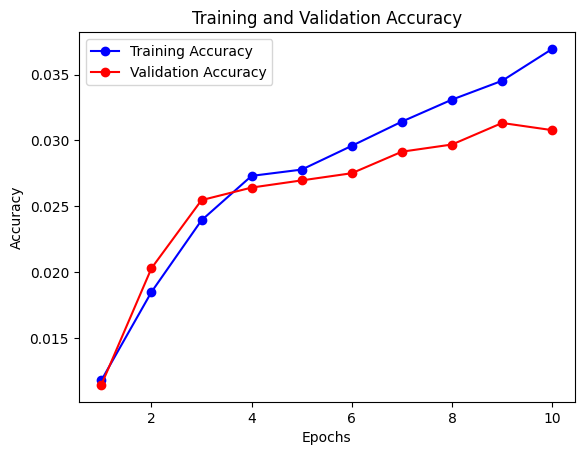

In [ ]:
import matplotlib.pyplot as plt

# Modeli eğit
history = model.fit(X_train_padded, y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test_one_hot))

# Eğitim sürecindeki doğruluk değerlerini alın
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Epoch accuracy grafiğini çizdirin
epochs = range(1, len(train_accuracy) + 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
import pandas as pd

# Tahmin sonuçlarını DataFrame'e dönüştürme
predictions_df = pd.DataFrame({'Prediction': label_encoder.inverse_transform(np.argmax(predictions, axis=1))})

# DataFrame'i Excel dosyasına kaydetme
predictions_df.to_excel('predictions.xlsx', index=False)

In [ ]:
from google.colab import files
files.download("predictions.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
drive.mount('/content/gdrive')
veri=pd.read_excel("/content/gdrive/My Drive/Deneme/filtered_data.xlsx")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Veri ön işleme
veri = veri.dropna(subset=['findings', 'impression'])  # Boş değerleri kaldırma

X = veri['findings'].values  # Bulguları X'e ata
y = veri['impression'].values  # Sonuçları y'ye ata

# Metin verilerini sayısal vektörlere dönüştürme
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

# Eğitim ve test setlerini oluşturma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Veri setlerini sabit uzunluğa doldurma
max_sequence_length = 100  # Belirli bir maksimum dizi uzunluğu seçebilirsiniz
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

# Modelin oluşturulması
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
# LabelEncoder oluşturma ve sınıfları uygun şekilde dönüştürme
label_encoder = LabelEncoder()
y_combined = np.concatenate((y_train, y_test), axis=0)
label_encoder.fit(y_combined)

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes)



In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
max_words = len(tokenizer.word_index) + 1
# Metin verileri
texts = np.array(veri['impression'])
labels = np.array(veri['findings'])

# Etiketleri kodlama
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Verilerin eğitim ve test kümelerine bölünmesi
X_train, X_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, random_state=42)

# Metin verilerinin vektörize edilmesi
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Metin dizilerinin uzunluklarının kontrol edilmesi
max_length = max(len(sequence) for sequence in X_train)

# Verilerin dizilere dönüştürülmesi
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

# Sınıf sayısının belirlenmesi
num_classes = len(label_encoder.classes_)

# Etiketlerin kategorik formata dönüştürülmesi
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes)

# Modelin oluşturulması
model = Sequential()
model.add(Embedding(max_words, 100, input_length=max_length))
model.add(LSTM(128))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Modelin eğitimi
model.fit(X_train, y_train_one_hot, validation_data=(X_test, y_test_one_hot), epochs=5, batch_size=32)

Epoch 1/5
914/914 [==============================] - 66s 64ms/step - loss: 10.2256 - accuracy: 0.0099 - val_loss: 10.4853 - val_accuracy: 0.0105
Epoch 2/5
914/914 [==============================] - 23s 26ms/step - loss: 9.9032 - accuracy: 0.0151 - val_loss: 11.1603 - val_accuracy: 0.0229
Epoch 3/5
914/914 [==============================] - 22s 24ms/step - loss: 9.4623 - accuracy: 0.0268 - val_loss: 12.2199 - val_accuracy: 0.0307
Epoch 4/5
914/914 [==============================] - 24s 27ms/step - loss: 8.8237 - accuracy: 0.0303 - val_loss: 13.1277 - val_accuracy: 0.0334
Epoch 5/5
914/914 [==============================] - 20s 22ms/step - loss: 7.9842 - accuracy: 0.0340 - val_loss: 13.5864 - val_accuracy: 0.0352


In [ ]:
from keras.layers import GlobalMaxPooling1D
# Convert X_train and X_test to list of strings
X_train_texts = [str(text) for text in X_train]
X_test_texts = [str(text) for text in X_test]

# Preprocess the input data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train_texts)

X_train_sequences = tokenizer.texts_to_sequences(X_train_texts)
X_test_sequences = tokenizer.texts_to_sequences(X_test_texts)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post')

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes)

# Build and compile the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test_one_hot))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_one_hot)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)



# Make predictions
new_text = np.array(data['impression'])
new_text_sequences = tokenizer.texts_to_sequences(new_text)
new_text_padded = pad_sequences(new_text_sequences, maxlen=max_length, padding='post')

predictions = model.predict(new_text_padded)
predicted_label = label_encoder.inverse_transform([np.argmax(predictions[0])])
print('Prediction:', predicted_label)

ValueError: ignored

In [ ]:
from keras.optimizers import RMSprop
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 95, 100)           1000000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 32889)             4242681   
                                                                 
Total params: 5,359,929
Trainable params: 5,359,929
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
914/914 [==============================] - 26s 26ms/step - loss: 0.0024 - accuracy: 0.0123 - val_loss: 4.8719e-04 - val_accuracy: 0.0194
Epoch 2/10
914/914 [==============================] - 20s 22ms/step - loss: 3.3171e-04 - accuracy: 0.0201 - val_loss: 4.5180e-04 - val_accuracy: 0.0264
Epoch 3/10
914/914 [==============================] - 19s 21ms/step - loss: 3.1841e-04 - accuracy: 0.0262 - val_loss: 4.3214e-04 - val_accuracy: 0.0301
Epoch 4/10
914/914 [==============================] - 19s 21ms/step - loss: 3.0788e-04 - accuracy: 0.0281 - val_loss: 4.1688e-04 - val_accuracy: 0.0311
Epoch 5/10
914/914 [==============================] - 22s 24ms/step - loss: 3.0194e-04 - accuracy: 0.0300 - val_loss: 4.1538e-04 - val_accuracy: 0.0304
Epoch 6/10
914/914 [==============================] - 19s 21ms/step - loss: 2.9597e-04 - accuracy: 0.0307 - val_loss: 4.0459e-04 - val_accuracy: 0.0324
Epoch 7/10
914/914 [==============================] - 22s 24ms/step - loss: 2.9113e-04 - acc

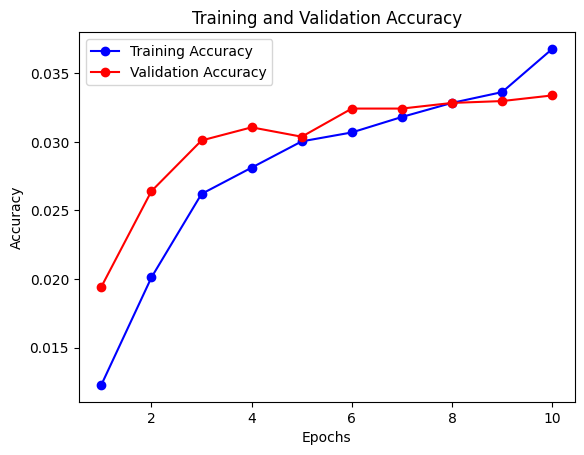

In [ ]:
import matplotlib.pyplot as plt

# Modeli eğit
history = model.fit(X_train_padded, y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test_one_hot))

# Eğitim sürecindeki doğruluk değerlerini alın
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Epoch accuracy grafiğini çizdirin
epochs = range(1, len(train_accuracy) + 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()